In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 8.3 MB/s 
     |████████████████████████████████| 77 kB 8.3 MB/s 
     |████████████████████████████████| 895 kB 70.9 MB/s 
     |████████████████████████████████| 6.6 MB 64.2 MB/s 
     |████████████████████████████████| 596 kB 68.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import numpy as np 
import pandas as pd 
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
import io
%matplotlib inline

In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
import gc
gc.collect()

154

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.chdir('drive/MyDrive/William_2022')

In [9]:
!ls

'CMU SAIL LITERATURE LECTURES.gsheet'  'Meeting Notes.gdoc'
 DATASETS			       'RESEARCH NOTES.gdoc'


In [7]:
df = pd.read_csv('DATASETS/CSV/full_transcript_concat.csv')

In [8]:
df['arousal_trans'] = df['arousal_trans'].round()
df['arousal2_trans'] = df['arousal2_trans'].round()

df['valence_trans'] = df['valence_trans'].round()
df['valence2_trans'] = df['valence2_trans'].round()

df['happy_trans'] = df['happy_trans'].round()
df['happy2_trans'] = df['happy2_trans'].round()

df['angry_trans'] = df['angry_trans'].round()
df['angry2_trans'] = df['angry2_trans'].round()

df['nervous_trans'] = df['nervous_trans'].round()
df['nervous2_trans'] = df['nervous2_trans'].round()

df['sad_trans'] = df['sad_trans'].round()
df['sad2_trans'] = df['sad2_trans'].round()

In [9]:
df1 = df[['new_words', 'happy_trans']]

In [10]:
df1['happy_trans'] = df1['happy_trans'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
RANDOM_SEED = 41

df_train, df_test = train_test_split(
  df1,
  test_size=0.2,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [12]:
df = pd.concat([df_train,df_test,df_val])

In [13]:
df

,new_words,happy_trans
482,for Koreans that we ourselves were officials o...,2
299,that these refugees can get into and therefore...,1
266,of Korea issue and I think me to take more care,1
16,for for Korea being under the UN Refugee Conve...,2
489,which stated that six people were killed which...,2
...,...,...
1388,paper saying fake refugees and everything I do...,1
801,to go to military because of the situation I b...,1
783,discrimination upon arriving South Korea howev...,1
1022,larger in Korea because the culture itself is,1


In [13]:
def to_emotion(rating):
  rating = int(rating)
  if rating == 2:
    return 'low'
  elif rating == 3:
    return 'high'
  else: 
    return 'very low'

df['happy_trans'] = df.happy_trans.apply(to_emotion)

In [14]:
df['happy_trans'].value_counts()

very low    1231
low          608
high          24
Name: happy_trans, dtype: int64

In [16]:
df = df.reset_index()

In [22]:
df

,new_words,happy_trans,label_enc
0,for Koreans that we ourselves were officials o...,low,1
1,that these refugees can get into and therefore...,very low,2
2,of Korea issue and I think me to take more care,very low,2
3,for for Korea being under the UN Refugee Conve...,low,1
4,which stated that six people were killed which...,low,1
...,...,...,...
1858,paper saying fake refugees and everything I do...,very low,2
1859,to go to military because of the situation I b...,very low,2
1860,discrimination upon arriving South Korea howev...,very low,2
1861,larger in Korea because the culture itself is,very low,2


In [17]:
df = df.drop(['index'], axis = 1)

In [19]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['label_enc'] = labelencoder.fit_transform(df['happy_trans'])

In [80]:
df['label'].value_counts()

2    1231
1     608
0      24
Name: label, dtype: int64

In [23]:
df.rename(columns={'happy_trans':'label_desc'},inplace=True)
df.rename(columns={'label_enc':'label'},inplace=True)

In [78]:
df

,new_words,label_desc,label
0,for Koreans that we ourselves were officials o...,low,1
1,that these refugees can get into and therefore...,very low,2
2,of Korea issue and I think me to take more care,very low,2
3,for for Korea being under the UN Refugee Conve...,low,1
4,which stated that six people were killed which...,low,1
...,...,...,...
1858,paper saying fake refugees and everything I do...,very low,2
1859,to go to military because of the situation I b...,very low,2
1860,discrimination upon arriving South Korea howev...,very low,2
1861,larger in Korea because the culture itself is,very low,2


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [26]:
device = torch.device("cuda")

In [27]:
sentences = df.new_words.values

In [23]:
sentences.shape

(1863,)

In [28]:
print("Distribution of data based on labels: ",df1.happy_trans.value_counts())

Distribution of data based on labels:  1    1231
2     608
3      24
Name: happy_trans, dtype: int64


In [30]:
MAX_LEN = 100

tokenizer = BertTokenizer.from_pretrained('bert-base-cased',do_lower_case=True)
input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in sentences]
labels = df.label.values

print("Actual sentence before tokenization: ",sentences[2])
print("Encoded Input from dataset: ",input_ids[2])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Actual sentence before tokenization:  of Korea issue and I think me to take more care
Encoded Input from dataset:  [101, 1104, 180, 4474, 1161, 2486, 1105, 178, 1341, 1143, 1106, 1321, 1167, 1920, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
attention_masks = []

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
print(attention_masks[2])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [32]:
#stratified k fold

train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(input_ids,labels,random_state=41,test_size=0.1)
train_masks,validation_masks,_,_ = train_test_split(attention_masks,input_ids,random_state=41,test_size=0.1)

In [33]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 20

train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [44]:
train_data[3]


(tensor([  101,  1138,   170, 17000,  2340, 15328, 22648,  1104, 26948,  1116,
          1106,  1106,  1176,  1152,   112,  1231,  1280,  1106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [61]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)

lr = 2e-5
adam_epsilon = 1e-8

epochs = 25

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [62]:

train_loss_set = []
learning_rate = []

model.zero_grad()

for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")
  batch_loss = 0

  for step, batch in enumerate(train_dataloader):
    model.train()
    
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    loss.backward()
    
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()
    
    scheduler.step()

    optimizer.zero_grad()
    
    batch_loss += loss.item()

  avg_train_loss = batch_loss / len(train_dataloader)

  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
    
  # Validation


  model.eval()

  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  1.9200000000000003e-05

	Average Training loss: 0.7270497019801822

	Validation Accuracy: 0.7007142857142857

	Validation MCC Accuracy: 0.0
<====================== Epoch 2 ======================>

	Current Learning rate:  1.8400000000000003e-05

	Average Training loss: 0.7047039412316822

	Validation Accuracy: 0.6914285714285715

	Validation MCC Accuracy: 0.0
<====================== Epoch 3 ======================>

	Current Learning rate:  1.76e-05

	Average Training loss: 0.7050643573914256

	Validation Accuracy: 0.6635714285714285

	Validation MCC Accuracy: 0.0
<====================== Epoch 4 ======================>

	Current Learning rate:  1.6800000000000002e-05

	Average Training loss: 0.7072706215438389

	Validation Accuracy: 0.6728571428571428

	Validation MCC Accuracy: 0.0
<====================== Epoch 5 ======================>

	Current Learning rate:  1.6000000000000003e-05

	Average Training lo

In [63]:
outputs[0]

tensor(0.8302, device='cuda:0', grad_fn=<NllLossBackward0>)

In [64]:
labels_flat

array([2, 2, 2, 2, 2, 1, 0])

In [65]:
pred_flat

array([2, 2, 2, 2, 2, 2, 2])

In [66]:
tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)

In [67]:
tmp_eval_mcc_accuracy

0.0

In [68]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [69]:
cm = confusion_matrix(labels_flat, pred_flat)

Confusion matrix, without normalization
[[0 0 1]
 [0 0 1]
 [0 0 5]]


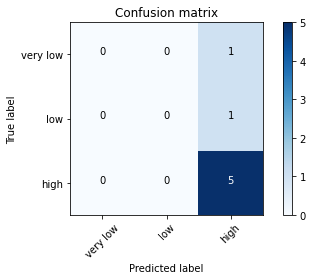

In [71]:
plot_confusion_matrix(cm, ['very low','low', 'high'])

In [47]:
df[['label','label_desc']].drop_duplicates(keep='first')

,label,label_desc
0,1,low
1,2,very low
8,0,high


In [77]:
df_metrics

,Epoch,Actual_class,Predicted_class
0,25,2,2
1,25,2,2
2,25,2,2
3,25,2,2
4,25,2,2
5,25,1,2
6,25,0,2


In [72]:
label2int = {
  "very low": 0,
  "low": 1,
  "high": 2
}

In [37]:
label2int = {
  0 : "very low",
  1 : "low",
  2 :"high"
}

In [76]:
label2int.keys()

dict_keys(['very low', 'low', 'high'])

In [75]:
 df_metrics['Predicted_class'].unique()


array([2])

In [73]:
print(classification_report(df_metrics['Actual_class'].values, df_metrics['Predicted_class'].values, target_names=label2int.keys(), digits=len(label2int)))

              precision    recall  f1-score   support

    very low      0.000     0.000     0.000         1
         low      0.000     0.000     0.000         1
        high      0.714     1.000     0.833         5

    accuracy                          0.714         7
   macro avg      0.238     0.333     0.278         7
weighted avg      0.510     0.714     0.595         7



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [82]:
!ls

'CMU SAIL LITERATURE LECTURES.gsheet'  'Meeting Notes.gdoc'
 DATASETS			       'RESEARCH NOTES.gdoc'


In [83]:

model.save_pretrained('DATASETS')
tokenizer.save_pretrained('DATASETS')

model_save_name = 'happy_fineTuneModel.pt'
path = path_model = F'{model_save_name}'
torch.save(model.state_dict(),path)